In [45]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
Base = automap_base()

Base.prepare(engine, reflect=True)

In [7]:

Base.classes.keys()

['measurement', 'station']

In [8]:

Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:

session = Session(engine)

# Exploratory Climate Analysis

## Precipitation Over Time 

In [10]:
last_date_query = session.query(Measurement.date).order_by(Measurement.id.desc()).limit(1)

for item in last_date_query:
    last_date = dt.datetime.strptime(item.date, "%Y-%m-%d").date() - dt.timedelta(days=364)

In [11]:
last_year_query = session.query(Measurement.date, func.avg(Measurement.prcp).label('Average')).\
        filter(Measurement.date >= last_date).\
        order_by(Measurement.date.asc()).\
        group_by(Measurement.date)

In [12]:
year_precip = session.query(Measurement.date, func.avg(Measurement.prcp).label('Average')).\
        filter(Measurement.date >= last_date).\
        order_by(Measurement.date.asc()).\
        group_by(Measurement.date)

precip_dict = {}
for day in year_precip:
    date = day.date
    prcp = day.Average
    precip_dict[date] = prcp

precip_dict

{'2016-08-24': 1.5549999999999997,
 '2016-08-25': 0.07714285714285715,
 '2016-08-26': 0.016666666666666666,
 '2016-08-27': 0.06399999999999999,
 '2016-08-28': 0.5166666666666666,
 '2016-08-29': 0.24333333333333332,
 '2016-08-30': 0.011666666666666667,
 '2016-08-31': 0.6359999999999999,
 '2016-09-01': 0.006,
 '2016-09-02': 0.05,
 '2016-09-03': 0.254,
 '2016-09-04': 0.276,
 '2016-09-05': 0.08499999999999999,
 '2016-09-06': 0.246,
 '2016-09-07': 0.3333333333333333,
 '2016-09-08': 0.07666666666666667,
 '2016-09-09': 0.17833333333333332,
 '2016-09-10': 0.27999999999999997,
 '2016-09-11': 0.25,
 '2016-09-12': 0.308,
 '2016-09-13': 0.45166666666666666,
 '2016-09-14': 2.3800000000000003,
 '2016-09-15': 0.8266666666666667,
 '2016-09-16': 0.11714285714285715,
 '2016-09-17': 0.13599999999999998,
 '2016-09-18': 0.10600000000000001,
 '2016-09-19': 0.064,
 '2016-09-20': 0.14714285714285716,
 '2016-09-21': 0.19499999999999998,
 '2016-09-22': 0.2057142857142857,
 '2016-09-23': 0.22428571428571428,
 '2

In [13]:
dates = [item.date for item in last_year_query]
precipitation = [item.Average for item in last_year_query]

In [14]:
precip_df = pd.DataFrame(precipitation, index=dates, columns=['Avg Precipitation'])
precip_df.head()

,Avg Precipitation
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


In [76]:
plt.rcParams["figure.figsize"] = (15,10)

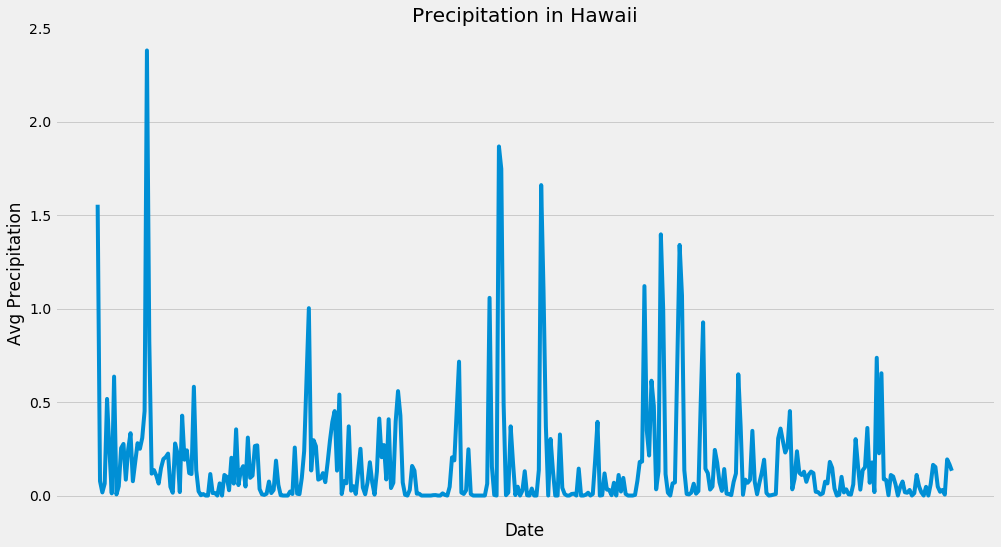

In [60]:
plt.plot(precip_df)
plt.xlabel('Date')
plt.ylabel('Avg Precipitation')
plt.title('Precipitation in Hawaii')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=50))
plt.gcf().autofmt_xdate()


In [16]:
precip_df.describe()

,Avg Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


## Weather Station Information and Observations

In [17]:
stations_query = session.query(func.count(Station.id)).all()
stations_query

[(9)]

In [18]:
station_info = session.query(Measurement.station, func.count(Measurement.station).label('Count')).\
        order_by(func.count(Measurement.station).desc()).\
        group_by(Measurement.station).all()
station_info

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
top_station = station_info[0][0]

most_active_info = session.query(Measurement.station, func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs) ).\
    filter(Measurement.station == station_info[0][0]).all()

most_active_info

[('USC00519281', 85.0, 54.0, 71.66378066378067)]

In [20]:
most_active_tobs = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == top_station).all()

observations = list(zip(*most_active_tobs))[1]

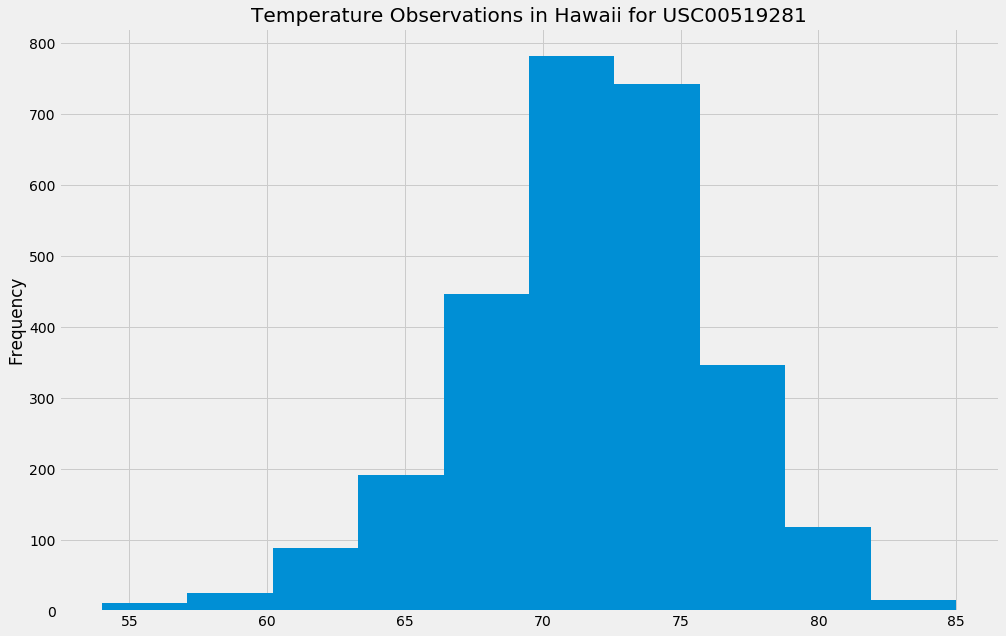

In [78]:
plt.hist(observations)
plt.ylabel("Frequency")
fig_title = f"Temperature Observations in Hawaii for {top_station}"
plt.title(fig_title)
plt.show()

## Trip Temperature Average and Range

In [24]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()


print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [25]:
trip = {'start':'2017-05-01', 'end':'2017-05-14'}

my_trip_info = calc_temps(trip['start'], trip['end'])[0]

print(my_trip_info)


(65.0, 75.21794871794872, 80.0)


In [65]:
plt.rcParams["figure.figsize"] = (4,10)

Text(0.5, 1.0, 'Temperature Avg and Range')

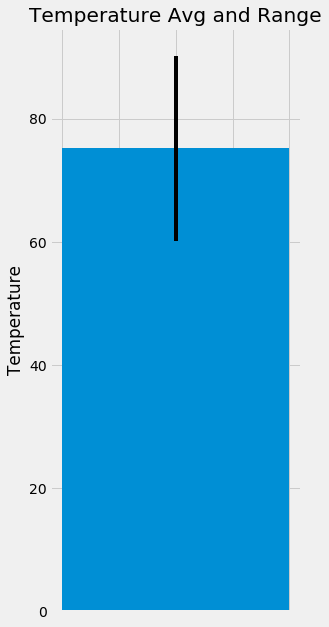

In [73]:
temp_range = my_trip_info[2] - my_trip_info[0]

plt.bar(1,my_trip_info[1], yerr = temp_range)
plt.tick_params(axis='x',bottom=False,labelbottom=False)
plt.ylabel('Temperature')
plt.title('Temperature Avg and Range')

In [27]:
sel = [Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp).label('Total Precipitation')]

trip_precip = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp).label('Total Precipitation')).\
        filter(Measurement.date >= trip['start'], Measurement.date <= trip['end'],Station.station == Measurement.station).\
        order_by(func.sum(Measurement.prcp).desc()).\
        group_by(Station.station).all()

trip_precip



[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  3.9100000000000006),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  3.1100000000000003),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  2.2099999999999995),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  1.94),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.81),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.27)]

## Daily Temperature Normals and Expected Temperature

In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
trip_diff = dt.datetime.strptime(trip['end'],"%Y-%m-%d") - dt.datetime.strptime(trip['start'],"%Y-%m-%d")

trip_length = trip_diff.days + 1

start_date = dt.datetime.strptime(trip['start'],"%Y-%m-%d")

trip_range = [start_date + dt.timedelta(days=int(x)) for x in np.arange(trip_length)]

trip_range_str = [dt.datetime.strftime(x,"%m-%d") for x in trip_range]

normals = []

for date in trip_range_str:
    normals.append(daily_normals(date)[0])


In [31]:
trip_dates = [dt.datetime.strftime(x,"%Y-%m-%d") for x in trip_range]

normals_df = pd.DataFrame(normals,index=trip_dates,columns=['Min','Avg','Max'])

normals_df

,Min,Avg,Max
2017-05-01,65.0,72.759259,79.0
2017-05-02,65.0,73.050847,79.0
2017-05-03,67.0,73.410714,84.0
2017-05-04,65.0,73.596491,78.0
2017-05-05,67.0,73.396552,79.0
2017-05-06,66.0,73.140351,80.0
2017-05-07,64.0,71.788462,79.0
2017-05-08,65.0,72.188679,80.0
2017-05-09,67.0,72.932203,79.0
2017-05-10,64.0,73.315789,78.0


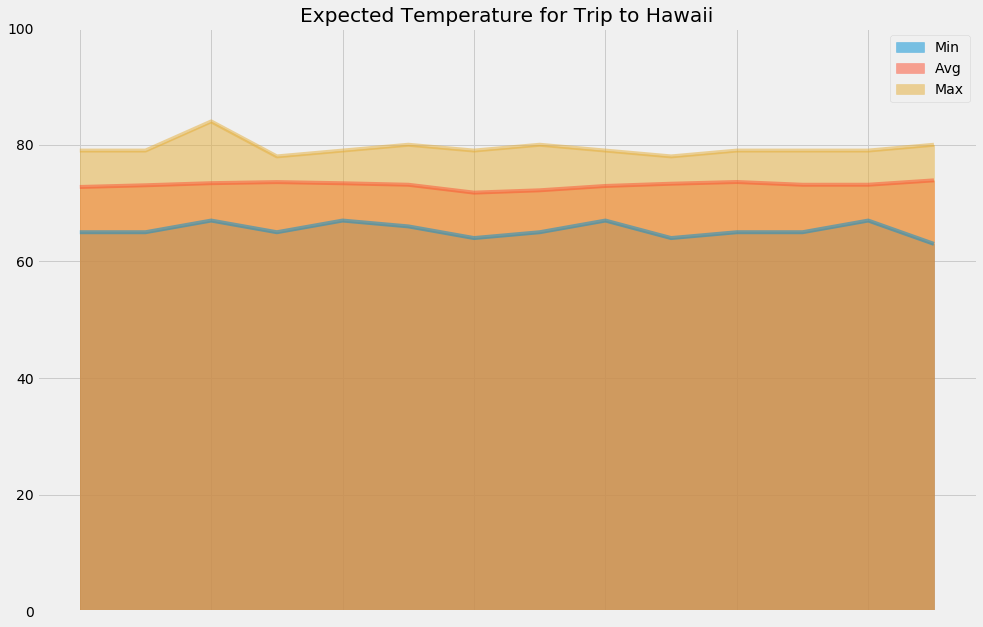

In [82]:
normals_df.plot.area(stacked=False)
plt.title("Expected Temperature for Trip to Hawaii")
plt.ylim(0,100)
plt.show()